In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
from CENSAr.datasources import (
    personas_radios_prov,
    tipoviv_radios_prov,
    radios_prov,
    radios_eph_censo_2010,
    persproy_depto_2025,
)
import h3pandas

In [4]:
from CENSAr.spatial_distributions.modeling_tools import simulate_total_var, simulate_cat_var

In [5]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx="08")
chaco_2001 = radios_prov(year=2001, prov="chaco", mask=envolvente)
chaco_2010 = radios_prov(year=2010, prov="chaco", mask=envolvente)

[12:58:23] INFO     https://storage.googleapis.com/python_mdg/censar_carto/radios_eph_json.zip   ]8;id=178516;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=847209;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#102\102]8;;\

In [6]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(
    year=2001,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2001_geo = chaco_2001.set_index("link").join(tipo_2001.set_index("link"))
tipo_2010 = tipoviv_radios_prov(
    year=2010,
    prov="chaco",
    var_types={"link": "object"},
)
tipo_2010_geo = chaco_2010.set_index("link").join(tipo_2010.set_index("link"))

[12:58:56] INFO     loading                                                                      ]8;id=336517;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=20049;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#111\111]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2001.csv`                                                                                

           INFO     loading                                                                      ]8;id=321785;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=406506;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#111\111]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    chaco_2010.csv`                                                                                

In [7]:
# TABLAS REDATAM - PERSONAS
pers_2001 = personas_radios_prov(year=2001, prov="chaco", var_types={"link": "object"})
pers_2001_geo = chaco_2001.set_index("link").join(pers_2001.set_index("link"))
pers_2010 = personas_radios_prov(year=2010, prov="chaco", var_types={"link": "object"})
pers_2010_geo = chaco_2010.set_index("link").join(pers_2010.set_index("link"))

[12:58:57] INFO     loading                                                                      ]8;id=772093;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=207586;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#133\133]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/personas_radios_chaco                   
                    _2001.csv`                                                                                     

           INFO     loading                                                                      ]8;id=48562;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=57137;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#133\133]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/personas_radios_chaco                   
                    _2010.csv`                                                                                     

In [8]:
# Tabla de proyecciones de poblacion por departamento
proy = persproy_depto_2025(prov="chaco")

           INFO     loading,                                                                     ]8;id=632867;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=103081;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#167\167]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/persproyect_depto_cha                   
                    co.csv`                                                                                        

In [9]:
# Total viviendas 2020
tipo_2010_geo["total_2020"] = simulate_total_var(
    gdf_pers_01=pers_2001_geo,
    gdf_var_01=tipo_2001_geo,
    gdf_pers_10=pers_2010_geo,
    gdf_var_10=tipo_2010_geo,
    estimate_totals={'proy_df': proy, 'namedept': 'San Fernando'},
    base_year="2010",
    forecast_year="2020",
    catname="total",
)

Estimating population totals
The ratio persons/dwelling units for 2010 is 3.35
The total number of projected households/residential units is 132131


<Axes: >

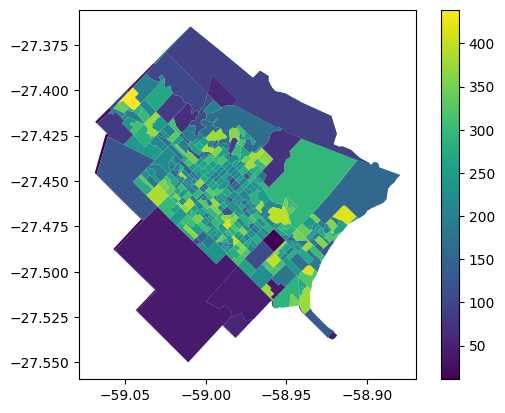

In [10]:
tipo_2001_geo.plot(column="total", legend=True)

/home/fede/CEEU/CENSAr/venvar/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/home/fede/CEEU/CENSAr/venvar/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/home/fede/CEEU/CENSAr/venvar/lib/python3.10/

<Axes: >

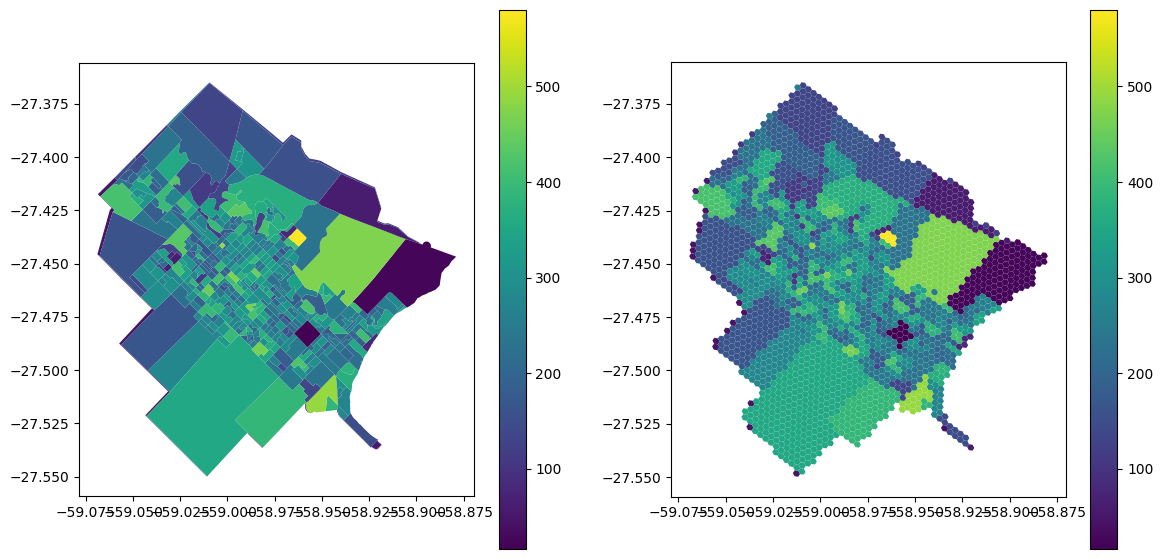

In [11]:
from CENSAr.clustering.geo_utils import geopandas_to_h3

fig, subplots = plt.subplots(1, 2, figsize=(14, 7))


tipo_2010_h3 = geopandas_to_h3(tipo_2010_geo, 9)

tipo_2010_geo.plot(column="total", legend=True, ax=subplots[0])
tipo_2010_h3.plot(column="total", legend=True, ax=subplots[1])

In [12]:
from esda.moran import Moran, Moran_Local
from libpysal import weights  # Spatial weights

In [13]:
w_queen = weights.Queen.from_dataframe(tipo_2010_h3)
w_knn = weights.KNN.from_dataframe(tipo_2010_h3, k=5)

In [14]:
moran = Moran(tipo_2010_h3["total"], w_queen)
lisa = Moran_Local(tipo_2010_h3["total"], w_queen)

In [15]:
is_significant = lisa.p_sim < 0.05
is_significant * lisa.q

array([0, 0, 0, ..., 3, 3, 3])

<Axes: ylabel='Density'>

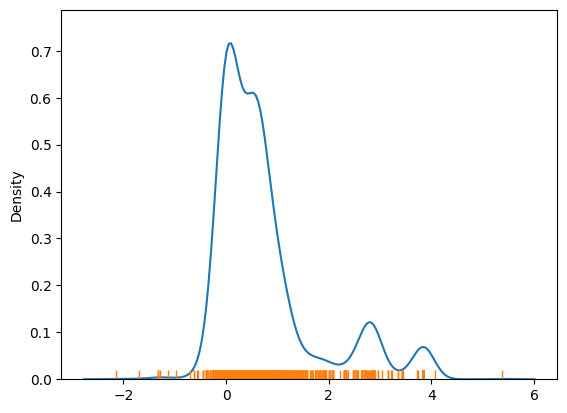

In [16]:
import seaborn as sns

sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is)

In [17]:
from splot import esda as esdaplot

(<Figure size 1400x700 with 3 Axes>, <Axes: >)

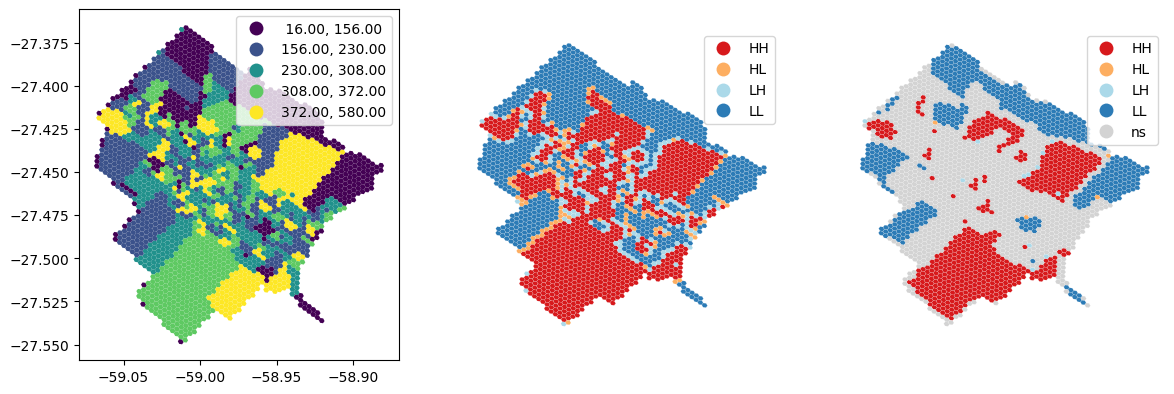

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

tipo_2010_h3.plot(column="total", legend=True, ax=ax[0], scheme="quantiles")
esdaplot.lisa_cluster(lisa, tipo_2010_h3, p=1, ax=ax[1])
esdaplot.lisa_cluster(lisa, tipo_2010_h3, p=0.05, ax=ax[2])

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>)

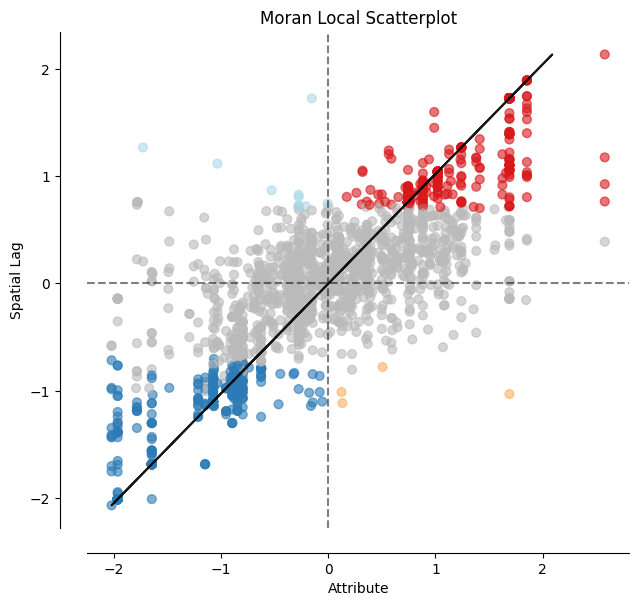

In [19]:
esdaplot.moran_scatterplot(lisa, p=0.05)